https://www.kaggle.com/competitions/store-sales-time-series-forecasting

In [1]:
import pandas as pd
import numpy as np
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_log_error
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor
from catboost import cv, Pool

import optuna

C:\Users\Fury\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\Fury\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
%%time
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

holidays_events = pd.read_csv('holidays_events.csv')
oil_df = pd.read_csv('oil.csv')
stores_df = pd.read_csv('stores.csv')
# transactions_df = pd.read_csv('transactions.csv')

CPU times: total: 1.25 s
Wall time: 1.24 s


### data cleaning

In [3]:
def preprocess(df):
    
    df_l = df.copy()
    
    df_l = df_l.merge(stores_df,
                      on='store_nbr',
                      how='left',
                      validate='m:1').rename(columns={'type': 'store_type'})

    df_l = df_l.merge(holidays_events.drop_duplicates(subset=['date', 'locale_name']),
                      left_on=['date', 'city'],
                      right_on=['date', 'locale_name'],
                      how='left', validate='m:1').rename(columns={'type': 'holiday_type'})

    df_l = df_l.merge(oil_df, on='date', how='left', validate='m:1')
    
    df_l = df_l.drop(['locale', 'locale_name', 'description', 'transferred'], axis=1)
    
    df_l['dcoilwtico'] = df_l['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
    df_l['holiday_type'] = np.where(df_l['holiday_type'].isin(['Holiday', 'Additional']), 1, 0)
    
    df_l['date'] = pd.to_datetime(df_l['date'])
    
    return df_l

In [4]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

C:\Users\Fury\AppData\Local\Temp\ipykernel_25812\2485515357.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_l['dcoilwtico'] = df_l['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')
C:\Users\Fury\AppData\Local\Temp\ipykernel_25812\2485515357.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_l['dcoilwtico'] = df_l['dcoilwtico'].fillna(method='ffill').fillna(method='bfill')


# Month predict

In [5]:
train_df_month_sales = pd.concat([train_df, test_df], ignore_index=True)
# train_df_month_sales = train_df_month_sales[train_df_month_sales['date']<'2017-08-01']

In [6]:
GROUP_COLS = ['date', 'city', 'state', 'store_type', 'cluster', 'store_nbr', 'family']

In [7]:
def group_data(df):
    
    df['date'] = df['date'].apply(lambda x: x.replace(day=1))
    
    df = df.groupby(GROUP_COLS, as_index=False).agg(
                                            sales=('sales', 'sum'),
                                            onpromotion=('onpromotion', 'sum'),
                                            dcoilwtico_mean=('dcoilwtico', 'mean'))
    
    return df

In [8]:
train_df_month_sale_gr = group_data(train_df_month_sales)

In [9]:
def add_time_related_features(df):
    
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month

    return df

In [10]:
train_df_month_sale_gr = add_time_related_features(train_df_month_sale_gr)

In [21]:
def create_time_series_features(df):
    
    group_cols = [x for x in GROUP_COLS if x != 'date']
    
    # lags
    for lag in [1, 2, 12]:
        df[f'sales_lag_{lag}'] = df.groupby(group_cols)['sales'].shift(lag)
        
    # rolling
    for window in [3, 6]:
        df[f'sales_roll_mean_{window}'] = (df.groupby(group_cols)['sales']
                                           .apply(lambda x: x.shift(1).rolling(window=window).mean())).values
        df[f'sales_roll_std_{window}'] = (df.groupby(group_cols)['sales']
                                           .apply(lambda x: x.shift(1).rolling(window=window).std())).values
        
    # trends
    #df['sales_trend_1'] = df.groupby(group_cols)['sales'].apply(lambda x: x.shift(1).diff(1) / x.shift(2).replace(0, np.nan))
    #df['sales_trend_12'] = df.groupby(group_cols)['sales'].apply(lambda x: x.shift(1).diff(12) / x.shift(12).replace(0, np.nan))
    
    return df

In [22]:
train_df_month_sale_gr = create_time_series_features(train_df_month_sale_gr)

In [23]:
train_df_month_sale_gr = train_df_month_sale_gr[train_df_month_sale_gr.notna().all(axis=1)]
train_df_month_sale_gr = train_df_month_sale_gr[train_df_month_sale_gr['sales']!=0]

## fit month model

In [24]:
TRAIN_COLS = ['city', 'state', 'store_type', 'cluster', 'store_nbr', 'family',
              'onpromotion', 'dcoilwtico_mean',
              'year', 'quarter', 'month',
              'sales_lag_1', 'sales_lag_2', 'sales_lag_12',
              'sales_roll_mean_3', 'sales_roll_std_3', 'sales_roll_mean_6', 'sales_roll_std_6']

CAT_COLS = ['city', 'state', 'store_type', 'cluster', 'store_nbr', 'family']

TARGET_COL = 'sales'

In [25]:
TEST_DATES = ('2017-05-01', '2017-07-01')

CV_DATES = [('2016-08-01', '2016-10-01'),
            ('2016-11-01', '2017-01-01'),
            ('2017-02-01', '2017-04-01')]

In [26]:
# train / teest set
X_train = train_df_month_sale_gr[train_df_month_sale_gr['date']<TEST_DATES[0]]
y_train = train_df_month_sale_gr[train_df_month_sale_gr['date']<TEST_DATES[0]][TARGET_COL]

X_test = train_df_month_sale_gr[train_df_month_sale_gr['date'].between(TEST_DATES[0], TEST_DATES[1])]
y_test = train_df_month_sale_gr[train_df_month_sale_gr['date'].between(TEST_DATES[0], TEST_DATES[1])][TARGET_COL]

In [27]:
# cv indexes
cv_index = []

for start, end in CV_DATES:    
    cv_index = cv_index + [(X_train[X_train['date']<start].index, X_train[X_train['date'].between(start, end)].index)]

In [28]:
def objective(trial):
    
    # model params
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        
        'task_type': 'GPU',
        'devices':'0',
        
        'random_seed': 42,
        'cat_features': CAT_COLS,
        'verbose': 0,
        
        'iterations': 3000,
        'early_stopping_rounds': 100,
        
        'depth': trial.suggest_int('depth', 4, 12),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0)    
    }
    
    # cv
    scores = []
    best_iters = []
    
    for train_idx, val_idx in cv_index:
        X_train_t, X_val = X_train.loc[train_idx, TRAIN_COLS], X_train.loc[val_idx, TRAIN_COLS]
        y_train_t, y_val = y_train.loc[train_idx], y_train.loc[val_idx]

        model = CatBoostRegressor(**params)
        
        model.fit(X_train_t, y_train_t,
                  eval_set=[(X_val, y_val)],
                  verbose=0)

        preds = model.predict(X_val)        
        score = mean_squared_error(y_val, preds)**0.5
        scores.append(score)        
        best_iters.append(model.best_iteration_)
    
    trial.set_user_attr('best_iters', best_iters)
    trial.set_user_attr('scores_user', scores)
    return np.mean(scores)

In [29]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [30]:
# print(study.best_trial.values)
# print(study.best_trial.params)
# print(study.best_trial.user_attrs)

In [31]:
def get_model_month_forecast():
    
    model = CatBoostRegressor(
        loss_function='RMSE',    
        eval_metric='RMSE',

        verbose=100,

        task_type='GPU',
        devices='0',

        cat_features=CAT_COLS,
        random_seed=42,

        iterations=1572,
        depth=4,
        learning_rate=0.13639917010761166,
        l2_leaf_reg=5.725746232780621,
        random_strength=0.42190555364552496
    )
    
    return model

In [32]:
model_month_cb = get_model_month_forecast()
model_month_cb.fit(X=X_train[TRAIN_COLS], y=y_train, eval_set=(X_test[TRAIN_COLS], y_test))

0:	learn: 32299.8750275	test: 35856.1848203	best: 35856.1848203 (0)	total: 55.9ms	remaining: 1m 27s
100:	learn: 6242.3608303	test: 5483.1180423	best: 5483.1180423 (100)	total: 1.6s	remaining: 23.2s
200:	learn: 5401.9671632	test: 5277.0331717	best: 5247.8311117 (164)	total: 3.13s	remaining: 21.3s
300:	learn: 4916.7409992	test: 5127.0548012	best: 5103.5611432 (248)	total: 4.9s	remaining: 20.7s
400:	learn: 4592.2234436	test: 5045.4374830	best: 5038.7159511 (380)	total: 6.43s	remaining: 18.8s
500:	learn: 4362.9268953	test: 5020.9447409	best: 5017.4077707 (462)	total: 8s	remaining: 17.1s
600:	learn: 4179.7387264	test: 4899.1517917	best: 4899.1517917 (600)	total: 9.58s	remaining: 15.5s
700:	learn: 4013.9761220	test: 4856.1090794	best: 4856.1090794 (700)	total: 11.1s	remaining: 13.8s
800:	learn: 3885.9854008	test: 4826.4492305	best: 4826.4492305 (800)	total: 12.7s	remaining: 12.2s
900:	learn: 3724.1862685	test: 4804.3215215	best: 4798.4454354 (886)	total: 14.2s	remaining: 10.6s
1000:	learn: 3

In [33]:
y_preds = model_month_cb.predict(X_test[TRAIN_COLS])
y_resudials = y_test - y_preds

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


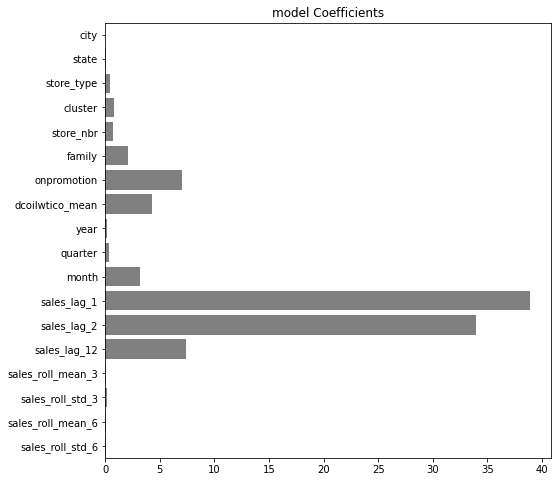

In [34]:
# Коэффициенты модели
plt.figure(figsize=(8, 8))
sns.barplot(model_month_cb.feature_importances_, model_month_cb.feature_names_, color='gray')
plt.title('model Coefficients')
plt.show()

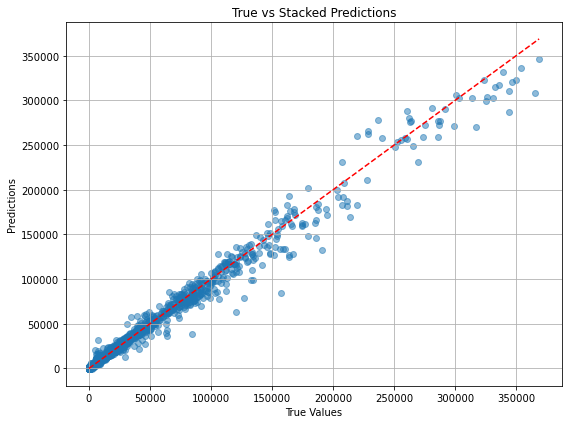

In [35]:
# прогноз vs факт
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Stacked Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

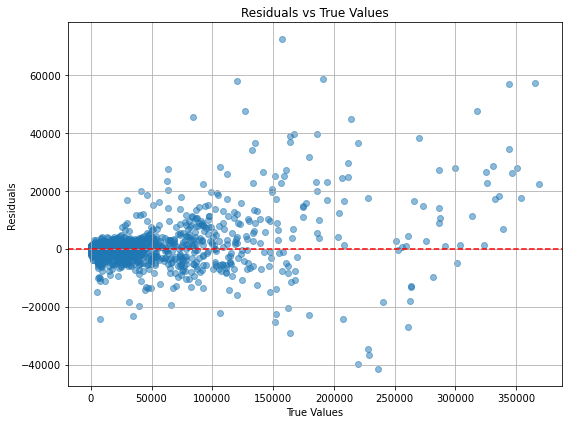

In [36]:
# ошибка
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_resudials, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

# Month predict to day predict

#### OOF month predict

In [37]:
CV_DATES_OOF = [('2016-01-01', '2016-05-01'),
                ('2016-06-01', '2016-10-01'),
                ('2016-11-01', '2017-03-01'),
                ('2017-04-01', '2017-08-01')]

df_month_predict = pd.DataFrame()

for start, end in CV_DATES_OOF:
    
    print(start)
    model_oof = get_model_month_forecast()
    model_oof.fit(X=train_df_month_sale_gr[train_df_month_sale_gr['date']<start][TRAIN_COLS],
                  y=train_df_month_sale_gr[train_df_month_sale_gr['date']<start][TARGET_COL],
                  verbose=1000)
    
    X_train_to_save = train_df_month_sale_gr[train_df_month_sale_gr['date'].between(start, end)].copy()
    X_train_to_save['month_sales_pred'] = model_oof.predict(X_train_to_save[TRAIN_COLS])
    
    df_month_predict = pd.concat([df_month_predict, X_train_to_save], ignore_index=False)

2016-01-01
0:	learn: 30805.5430494	total: 38.3ms	remaining: 1m
1000:	learn: 5050.6058044	total: 21.4s	remaining: 12.2s
1571:	learn: 4691.1041711	total: 34.5s	remaining: 0us
2016-06-01
0:	learn: 31283.6728348	total: 27.2ms	remaining: 42.7s
1000:	learn: 4922.0754428	total: 25s	remaining: 14.3s
1571:	learn: 4516.1965217	total: 38.5s	remaining: 0us
2016-11-01
0:	learn: 31426.1866744	total: 26ms	remaining: 40.8s
1000:	learn: 4921.4187854	total: 22.7s	remaining: 12.9s
1571:	learn: 4594.5156436	total: 35.7s	remaining: 0us
2017-04-01
0:	learn: 32186.1343941	total: 15.1ms	remaining: 23.8s
1000:	learn: 3662.1282232	total: 14.5s	remaining: 8.29s
1571:	learn: 3226.2113576	total: 22.8s	remaining: 0us


In [38]:
# fix
df_month_predict.loc[df_month_predict['month_sales_pred']<0, 'month_sales_pred'] = 0

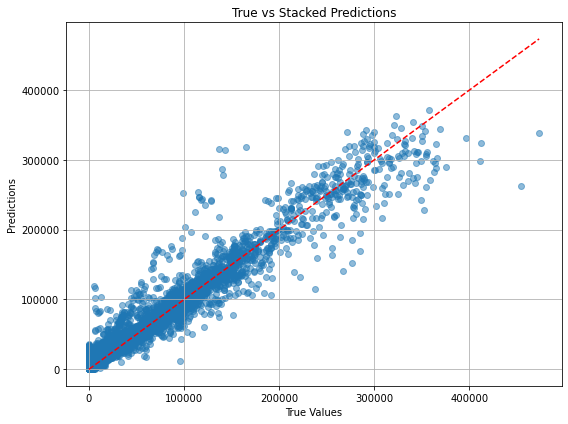

In [39]:
# прогноз vs факт
y_test, y_preds = df_month_predict['sales'], df_month_predict['month_sales_pred']

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_preds, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Stacked Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

In [40]:
# датасет для обучения прогноза на день
df_day_predict = train_df[train_df['date']>='2016-01-01'].copy()

df_day_predict['date_o'] = df_day_predict['date']
df_day_predict['date'] = df_day_predict['date'].apply(lambda x: x.replace(day=1))

df_day_predict = df_day_predict.merge(df_month_predict[['date', 'store_nbr', 'family', 'month_sales_pred']],
                                      how='left',
                                      on=['date', 'store_nbr', 'family'],
                                      validate='m:1')

df_day_predict['date'] = df_day_predict['date_o']
df_day_predict = df_day_predict.drop(columns=['date_o'])

df_day_predict['month_sales_pred'] = df_day_predict['month_sales_pred'].fillna(0)

In [41]:
def add_time_related_features_days(df):
    
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['week'] = df['date'].dt.isocalendar().week.astype('int64')
    df['day_of_week'] = df['date'].dt.dayofweek
    df['day_of_month'] = df['date'].dt.day

    return df

In [42]:
df_day_predict = add_time_related_features_days(df_day_predict)

In [43]:
DAY_TRAIN_COLS = ['city', 'state', 'store_type', 'cluster', 'store_nbr', 'family',
                  'onpromotion', 'dcoilwtico',
                  'holiday_type',
                  'month_sales_pred',
                  'year', 'quarter', 'month', 'week', 'day_of_week', 'day_of_month']

DAY_CAT_COLS = ['city', 'state', 'store_type', 'cluster', 'store_nbr', 'family', 'holiday_type']

DAY_TARGET_COL = 'sales'

In [44]:
X_day_train, X_day_test, y_day_train, y_day_test = train_test_split(df_day_predict[DAY_TRAIN_COLS],
                                                                    df_day_predict[DAY_TARGET_COL],
                                                                    test_size=0.25,
                                                                    random_state=42,
                                                                    shuffle=True)

In [45]:
def objective(trial):
    
    # model params
    params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        
        'task_type': 'GPU',
        'devices':'0',
        
        'random_seed': 42,
        'cat_features': DAY_CAT_COLS,
        'verbose': 0,
        
        'iterations': 1000,
        'early_stopping_rounds': 50,
        
        'depth': trial.suggest_int('depth', 4, 12),
        
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10, log=True),
        
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0)    
    }
    
    
    pool = Pool(X_day_train, y_day_train, cat_features=DAY_CAT_COLS)
    
    cv_results = cv(
        pool=pool,
        params=params,
        fold_count=3,
        partition_random_seed=42,
        verbose=False
    )
    
    return min(cv_results['test-RMSE-mean'])

In [46]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=50, show_progress_bar=True)

In [47]:
# print(study.best_trial.values)
# print(study.best_trial.params)

In [48]:
{'depth': 9, 'learning_rate': 0.25932080544151764, 'l2_leaf_reg': 7.389593064814448, 'random_strength': 0.7466604420380099}

{'depth': 9,
 'learning_rate': 0.25932080544151764,
 'l2_leaf_reg': 7.389593064814448,
 'random_strength': 0.7466604420380099}

In [49]:
def get_model_day_forecast():
    
    model = CatBoostRegressor(
        loss_function='RMSE',    
        eval_metric='RMSE',

        verbose=100,

        task_type='GPU',
        devices='0',

        cat_features=DAY_CAT_COLS,
        random_seed=42,

        iterations=1894,
        depth=9,
        learning_rate=0.25932080544151764,
        l2_leaf_reg=7.389593064814448,
        random_strength=0.7466604420380099
    )
    
    return model

In [50]:
model_day_cb = get_model_day_forecast()
model_day_cb.fit(X=X_day_train, y=y_day_train, eval_set=(X_day_test, y_day_test))

0:	learn: 1047.3075701	test: 1059.8292680	best: 1059.8292680 (0)	total: 185ms	remaining: 5m 50s
100:	learn: 293.0415423	test: 346.3449314	best: 346.3449314 (100)	total: 18.7s	remaining: 5m 31s
200:	learn: 261.4978642	test: 331.7996787	best: 331.7996787 (200)	total: 37.3s	remaining: 5m 14s
300:	learn: 240.9681487	test: 324.2938180	best: 324.2938180 (300)	total: 56.3s	remaining: 4m 57s
400:	learn: 223.2608999	test: 319.7844149	best: 319.7844149 (400)	total: 1m 14s	remaining: 4m 38s
500:	learn: 211.2903910	test: 315.0703987	best: 315.0703987 (500)	total: 1m 33s	remaining: 4m 21s
600:	learn: 199.7529986	test: 313.0796207	best: 313.0793231 (599)	total: 1m 53s	remaining: 4m 3s
700:	learn: 190.7488787	test: 310.4684881	best: 310.4684881 (700)	total: 2m 12s	remaining: 3m 45s
800:	learn: 182.1490648	test: 308.3186058	best: 308.3159108 (799)	total: 2m 31s	remaining: 3m 26s
900:	learn: 175.9837038	test: 306.8919761	best: 306.8919761 (900)	total: 2m 50s	remaining: 3m 8s
1000:	learn: 170.9897978	te

In [51]:
y_preds = model_day_cb.predict(X_day_test)
y_resudials = y_day_test - y_preds

In [52]:
print(r2_score(y_day_test, y_preds))
print(mean_absolute_error(y_day_test, y_preds))
print(mean_squared_error(y_day_test, y_preds)**0.5)

0.94903520070496
60.76068576788942
298.7980420434435


In [53]:
ttt = pd.DataFrame(data={'true': y_day_test, 'preds': y_preds})
ttt.loc[ttt['preds']<0, 'preds']=0

print(r2_score(ttt['true'], ttt['preds']))
print(mean_absolute_error(ttt['true'], ttt['preds']))
print(mean_squared_error(ttt['true'], ttt['preds'])**0.5)
print(mean_squared_log_error(ttt['true'], ttt['preds']))

0.9491018256647894
58.718009127001984
298.60267270824374
1.2479531173481075


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


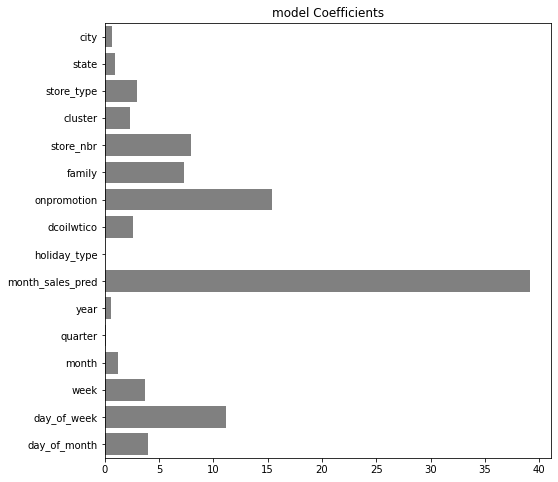

In [54]:
# Коэффициенты модели
plt.figure(figsize=(8, 8))
sns.barplot(model_day_cb.feature_importances_, model_day_cb.feature_names_, color='gray')
plt.title('model Coefficients')
plt.show()

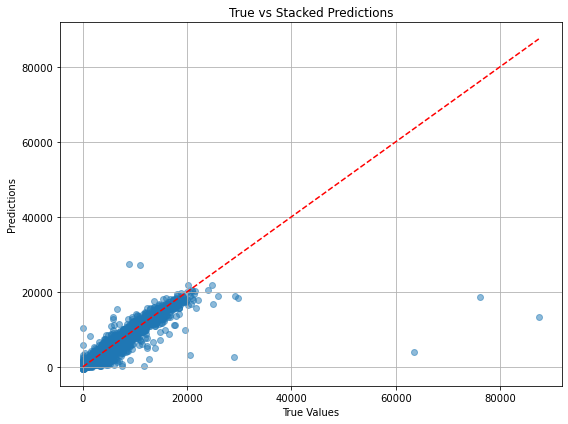

In [55]:
# прогноз vs факт
plt.figure(figsize=(8, 6))
plt.scatter(y_day_test, y_preds, alpha=0.5)
plt.plot([y_day_test.min(), y_day_test.max()], [y_day_test.min(), y_day_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("True vs Stacked Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()

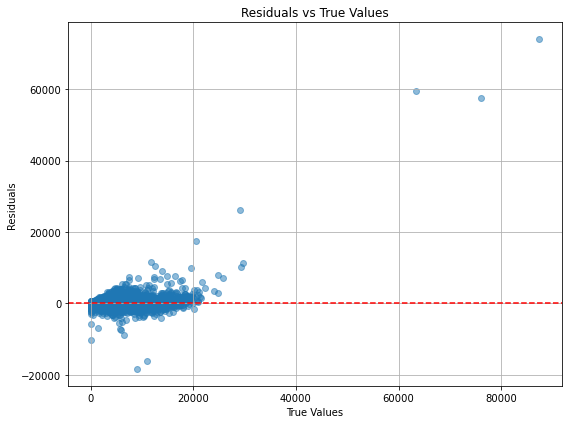

In [56]:
# resudial
plt.figure(figsize=(8, 6))
plt.scatter(y_day_test, y_resudials, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.title("Residuals vs True Values")
plt.grid(True)
plt.tight_layout()
plt.show()

## Predict

#### month

In [103]:
# month refit
model_month_cb_refit = get_model_month_forecast()
model_month_cb_refit.fit(X=train_df_month_sale_gr[train_df_month_sale_gr['date']<'2017-08-01'][TRAIN_COLS],
                         y=train_df_month_sale_gr[train_df_month_sale_gr['date']<'2017-08-01'][TARGET_COL])

0:	learn: 32576.1417398	total: 16.6ms	remaining: 26s
100:	learn: 6217.0138500	total: 1.57s	remaining: 22.8s
200:	learn: 5342.8568319	total: 3.1s	remaining: 21.1s
300:	learn: 4849.3195920	total: 4.57s	remaining: 19.3s
400:	learn: 4494.7986113	total: 6.06s	remaining: 17.7s
500:	learn: 4246.5994175	total: 7.58s	remaining: 16.2s
600:	learn: 4073.6408305	total: 9.03s	remaining: 14.6s
700:	learn: 3911.8475619	total: 10.6s	remaining: 13.1s
800:	learn: 3773.3313589	total: 12s	remaining: 11.6s
900:	learn: 3653.0657220	total: 13.6s	remaining: 10.1s
1000:	learn: 3549.3016688	total: 15.1s	remaining: 8.62s
1100:	learn: 3455.4417356	total: 16.6s	remaining: 7.12s
1200:	learn: 3383.1930269	total: 18.2s	remaining: 5.61s
1300:	learn: 3314.0469636	total: 19.7s	remaining: 4.11s
1400:	learn: 3244.8621954	total: 21.2s	remaining: 2.58s
1500:	learn: 3175.1423831	total: 22.7s	remaining: 1.07s
1571:	learn: 3130.1940711	total: 23.7s	remaining: 0us


In [104]:
# month predict
new_month_df = train_df_month_sale_gr[train_df_month_sale_gr['date']>='2017-08-01'].copy()
new_month_df['month_sales_pred'] = model_month_cb_refit.predict(new_month_df[TRAIN_COLS])

In [105]:
new_month_df.loc[new_month_df['month_sales_pred']<0, 'month_sales_pred'] = 0

#### day

In [106]:
# day refit
model_day_cb_refit = get_model_day_forecast()
model_day_cb_refit.fit(X=df_day_predict[DAY_TRAIN_COLS],
                       y=df_day_predict[DAY_TARGET_COL])

0:	learn: 1048.4511828	total: 240ms	remaining: 7m 34s
100:	learn: 299.1214119	total: 24.9s	remaining: 7m 21s
200:	learn: 263.9204116	total: 49.7s	remaining: 6m 58s
300:	learn: 242.2913881	total: 1m 15s	remaining: 6m 37s
400:	learn: 227.8548741	total: 1m 40s	remaining: 6m 12s
500:	learn: 216.2693047	total: 2m 5s	remaining: 5m 48s
600:	learn: 207.6240024	total: 2m 30s	remaining: 5m 23s
700:	learn: 199.5248227	total: 2m 56s	remaining: 4m 59s
800:	learn: 192.3646753	total: 3m 21s	remaining: 4m 35s
900:	learn: 185.1905706	total: 3m 47s	remaining: 4m 10s
1000:	learn: 178.9472645	total: 4m 13s	remaining: 3m 45s
1100:	learn: 174.9397327	total: 4m 38s	remaining: 3m 20s
1200:	learn: 170.8213422	total: 5m 4s	remaining: 2m 55s
1300:	learn: 167.3108860	total: 5m 30s	remaining: 2m 30s
1400:	learn: 163.4201804	total: 5m 56s	remaining: 2m 5s
1500:	learn: 158.6760340	total: 6m 22s	remaining: 1m 40s
1600:	learn: 155.4608721	total: 6m 48s	remaining: 1m 14s
1700:	learn: 152.3723569	total: 7m 15s	remaining

In [107]:
# датасет для обучения прогноза на день
df_day_predict_fin = test_df.copy()

df_day_predict_fin['date_o'] = df_day_predict_fin['date']
df_day_predict_fin['date'] = df_day_predict_fin['date'].apply(lambda x: x.replace(day=1))

df_day_predict_fin = df_day_predict_fin.merge(new_month_df[['date', 'store_nbr', 'family', 'month_sales_pred']],
                                              how='left',
                                              on=['date', 'store_nbr', 'family'],
                                              validate='m:1')

df_day_predict_fin['date'] = df_day_predict_fin['date_o']
df_day_predict_fin = df_day_predict_fin.drop(columns=['date_o'])

df_day_predict_fin['month_sales_pred'] = df_day_predict_fin['month_sales_pred'].fillna(0)

In [108]:
df_day_predict_fin = add_time_related_features_days(df_day_predict_fin)

In [129]:
df_day_predict_fin['preds'] =  model_day_cb_refit.predict(df_day_predict_fin[DAY_TRAIN_COLS])

In [130]:
df_day_predict_fin.loc[df_day_predict_fin['preds']<0, 'preds'] = 0

In [132]:
df_day_predict_fin['sales'] = df_day_predict_fin['preds']

In [133]:
df_day_predict_fin[['id', 'sales']].to_csv('first.csv', index=False)